# The Fermi-Pasta-Ulam-Tsingou Problem

In [63]:
"""
================================================================
        The Fermi-Pasta-Ulam-Tsingou (FPUT) Problem (1D)
================================================================
"""
from math import log10
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import os

#   Improve performance by applying 'jit' decorator
from numba import jit

__version__ = '1.0'


In [64]:
#   CONSTANTS & Parameters
N = 2 ** 6                                  #   Number of masses

ALPHA = 1.0                                 #   Linear spring constant
BETA = 1e-1                                 #   Nonlinear spring constant
# BETA = 0                                    #   No Nonlinear term

t_max = 1e4                                 #   Maximum time
dt_name = 2
dt = 2.5e-1                                   #   Time step
num_steps = int(np.ceil(t_max / dt)) + 1    #   Number of time steps
time_points = np.linspace(0, t_max, num_steps)

y0_amp = 1.0                                #   Initial displacement amplitude
                                            #   for the first and last points
config_str = f"{int(N)}_{int(ALPHA)}_{int(BETA)}_{int(log10(t_max))}_{dt_name}({int(log10(dt))})"

#   Parameters for the animation
if num_steps // (30 * 60) == 0:
    framestep = 1
else:
    framestep = num_steps // (30 * 60)      #   To ensure the GIF has 1800 frames


# <span style="color:red">Run simulations where particles 2+ *particles* away are affected by forces but effects of which are negligible</span>
Plot them against each other

Let there be $N$ oscillators representing a string of length $\ell$ with equilibrium positions $r_i = ih$, $i = 0,\dots,~N - 1$, where $h = \frac{\ell}{N - 1}$ is the lattice spacing

Then the position of the $i$-th oscillator as a function of time is $Y_i\left(t\right) = r_i + y_i\left(t\right)$, so that $y_i\left(t\right)$ gives the discplacement from equilibrium. FPUT used the following equations of motion:

$$m\ddot{y}_i = \alpha\left(y_{i + 1} + y_{i - 1} - 2y_i\right)\left[1 + \beta\left(y_{i + 1} - y_{i - 1}\right)\right]$$
where for unambiguity, $k = \alpha$

which is just Newton's second law for the $i$-th particle. The first factor $\alpha\left(y_{i + 1} + y_{i - 1} - 2y_i\right)$ is just the usual Hooke's law form for the force. The factor with $\beta$ is the nonlinear force

For all intents and purposes, $m$ is set to unity

Crucially, since this is a 1 dimensional model, we have to decide how we tackle the problem of the boundary particles. There are two approaches -- 1. periodic, and 2. fixed

In [65]:
#   Periodic boundary
@jit
def oneD_periodic(y, v):
    """
    List of ODEs of dvdt following periodic boundary conditions; dydt are all v
    
    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    
    :return v:      numpy array of dydt values
    :return dvdt:   numpy array of dvdt values
    """
    #   Displaces numpy array to the left and right for computation
    left_neighbors, right_neighbors = np.roll(y, 1), np.roll(y, -1)
    
    dvdt = ALPHA * (left_neighbors + right_neighbors - 2 * y) * (1 + BETA * (right_neighbors - left_neighbors))

    return v, dvdt


In [66]:
#   Fixed boundary
@jit
def oneD_fixed(y, v):
    """
    List of ODEs of dvdt following periodic boundary conditions; dydt are all v
    
    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    
    :return v:      numpy array of dydt values
    :return dvdt:   numpy array of dvdt values
    """
    dvdt = np.zeros_like(y)             #   Initialize dvdt
    
    #   Interior particles
    dvdt[1:N - 1] = ALPHA * (y[2:N] + y[:N - 2] - 2 * y[1:N - 1]) * (1 + BETA * (y[2:N] - y[:N - 2]))

    #   Boundary particles
    dvdt[0] = ALPHA * (y[1] - 2 * y[0]) * (1 + BETA * y[1])
    dvdt[N - 1] = ALPHA * (y[N - 2] - 2 * y[N - 1]) * (1 + BETA * (- y[N - 2]))

    return v, dvdt


By symmetry, the expression is notably one-dimensional, acting only on the direction perpendicular to the line spanning the equilibrium positions of the oscillators. For a two-dimensional set up, we will 

## ODE Solvers

In [67]:
#   Runge-Kutta 4th order method
@jit
def rk4_step(y, v, dt, func):
    """
    Runge-Kutta 4th order ODE Solver
    
    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    :param  dt:     timestep
    :param  func:   ODE expression

    :return y_next: numpy array of successive y values
    :return v_next: numpy array of successive v values
    """
    k1_y, k1_v = func(y, v)
    k2_y, k2_v = func(y + dt / 2 * k1_y, v + dt / 2 * k1_v)
    k3_y, k3_v = func(y + dt / 2 * k2_y, v + dt / 2 * k2_v)
    k4_y, k4_v = func(y + dt * k3_y, v + dt * k3_v)
    
    y_next = y + dt / 6 * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
    v_next = v + dt / 6 * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)
    
    return y_next, v_next

# Euler's method
@jit
def euler_step(y, v, dt, func):
    """
    Euler step ODE Solver

    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    :param  dt:     timestep
    :param  func:   ODE expression

    :return y_next: numpy array of successive y values
    :return v_next: numpy array of successive v values
    """
    dy, dv = func(y, v)
    
    y_next = y + dt * dy
    v_next = v + dt * dv

    return y_next, v_next

#   Efficient exponential time integration for simulating nonlinear coupled oscillators
#   https://www.sciencedirect.com/science/article/abs/pii/S0377042721000480

#   -- WIP--

# @jit
# def predictor_corrector_step(y, v, dt, func):
#     """
#     Euler step + Corrector ODE Solver
#     """
#     # Predictor step (Euler-like step for prediction)
#     y_pred, v_pred = euler_step(y, v, dt, func)
    
#     # Corrector step (Placeholder for nonlinear correction)
#     # In a true implementation, this would involve re-evaluating the nonlinear terms at the predicted state
#     # and applying a correction. We'll simulate this by a second application of the original function,
#     # which is not exactly how exponential Rosenbrock methods work but follows the predictor-corrector spirit.
#     dydt_corr, dvdt_corr = func(y_pred, v_pred, alpha, beta, N)
#     y_corr = y + dt * dydt_corr
#     v_corr = v + dt * dvdt_corr
    
#     return y_corr, v_corr


## Simulation
We perturb the system at one point (periodic boundary) or both ends (fixed boundary)

In [68]:
def simulator(ode_solver, expression):
    """
    Simulates time evolution of the oscillators

    :param  ode_solver: ODE Solving algorithm
    :param  expression: ODE expression
    
    :return d:          numpy array of displacements for each timestep
    :return v:          numpy array of velocities for each timestep
    """
    #   Initial conditions
    y = np.zeros(N)         #   Displacements
    v = np.zeros(N)         #   Velocities
    y[0] = y0_amp           #   Initial displacement of the first mass
    y[N - 1] = y0_amp       #   Initial displacement of the last mass

    #   Time evolution
    displacements = [y.copy()]      #   2D array of displacements at each time step
    velocities = [v.copy()]         #   2D array of velocities at each time step
    for _ in time_points:
        y, v = ode_solver(y, v, dt, expression)
        displacements.append(y.copy())
        velocities.append(v.copy())

    return np.array(displacements), np.array(velocities)

####################################################################################################
#                                                                                                  #
#                                    ABOVE CODE USED FOR SET UP                                    #
#                                                                                                  #
####################################################################################################

In [69]:
displacements_1D_periodic, velocities_1D_periodic = simulator(rk4_step, oneD_periodic)
displacements_1D_fixed, velocities_1D_fixed = simulator(rk4_step, oneD_fixed)


### Saving Data

In [70]:
#   Save numpy dump files
os.makedirs(f'./{config_str}', exist_ok = True)
# np.savetxt(f'./{config_str}/displacements_1D_periodic_{config_str}.txt', displacements_1D_periodic)
# np.savetxt(f'./{config_str}/velocities_1D_periodic_{config_str}.txt', velocities_1D_periodic)
# np.savetxt(f'./{config_str}/displacements_1D_fixed_{config_str}.txt', displacements_1D_fixed)
# np.savetxt(f'./{config_str}/velocities_1D_fixed_{config_str}.txt', velocities_1D_fixed)

In [71]:
def save_subset(filename, data):
    """
    Save data subset (corresponding to the gif)
    """
    subset = data[::framestep, int(np.ceil(N / 2))]
    np.savetxt(f'./subset_data/{filename}_{config_str}.txt', subset)

    return None


In [72]:
os.makedirs('./subset_data', exist_ok = True)

save_subset('displacements_1D_periodic', displacements_1D_fixed)
save_subset('displacements_1D_fixed', displacements_1D_periodic)
save_subset('velocities_1D_periodic', velocities_1D_periodic)
save_subset('velocities_1D_fixed', velocities_1D_fixed)


## GIF

In [73]:
def gif_plotter(filename, displacements):
    """
    GIF Plotter function v2.0

    Plots GIF visualizing time evolution of vertical displacements
    """
    fig, ax = plt.subplots()
    line, = ax.plot(displacements[0, :], '.', c = 'b')         #    Initial plot of displacement v.s. particle number

    #   Gridlines
    ax.axhline(y = 0, c = '#d3d3d3', lw = 0.5, ls = '-')
    ax.axvline(x = len(displacements[0]) - 1, c = '#d3d3d3', lw = 0.5, ls = '-')
    ax.axvline(x = 0, c = '#d3d3d3', lw = 0.5, ls = '-')

    #   Set plot limits and labels
    ax.set_ylim(- y0_amp, y0_amp)
    ax.set_xlabel(r'$n^{\text{th}}$ Particle')
    ax.set_ylabel('Displacement (units)')
    title = ax.set_title(f'Time: {0:.2f} units')
    fig.suptitle(f'{filename} ({N} particles)')

    #   Update the y-data of the plot to show the displacements at the current time step
    def update(frame):
        line.set_ydata(displacements[frame, :])              #    Successive plot of displacement v.s. particle number
        title.set_text(f'Time: {frame * dt:.2f} units')      #    Update elapsed time in title
        return line, title

    #   Creates and saves animation
    ani = FuncAnimation(fig, update, frames = range(0, num_steps, framestep), blit = True)
    ani.save(f'./{config_str}/{filename}_{config_str}.gif', writer = 'pillow', fps = 60)

    #   Close the plot
    plt.close()
    return None

####################################################################################################
#                                                                                                  #
#                                    ABOVE CODE USED FOR SET UP                                    #
#                                                                                                  #
####################################################################################################

In [74]:
# #   Plot gifs
# gif_plotter('displacements_1D_periodic', displacements_1D_periodic)
# gif_plotter('displacements_1D_fixed', displacements_1D_fixed)


## Mode Energy Analysis

In [75]:
def fft_plotter(filename, displacements):
    """
    FFT plotter function

    Plot graph visualizing energy distribution across modes
    """
    # Fourier Transform of Displacements to show energy distribution across FFT modes
    fourier_transform = np.fft.rfft(displacements[1:], axis = 1)
    mode_energies = np.abs(fourier_transform) ** 2

    plt.figure(figsize = (12, 5))
    for i in range(1, 5):  # First four modes after the zero mode
        plt.plot(np.linspace(0, num_steps - 1, num_steps) * dt, mode_energies[:, i], lw = 0.5, label = f'Mode {i}')

    #   Set plot limits and labels
    plt.grid(True)
    plt.xlabel('Time (units)')
    plt.ylabel('Mode Energy')
    plt.title('Energy in the First Four Modes Over Time')
    plt.suptitle(f'{filename} ({N} particles)')
    plt.legend()

    #   Saves plot
    plt.savefig(f'./{config_str}/{filename}_{config_str}_energy_modes.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

####################################################################################################
#                                                                                                  #
#                                    ABOVE CODE USED FOR SET UP                                    #
#                                                                                                  #
####################################################################################################

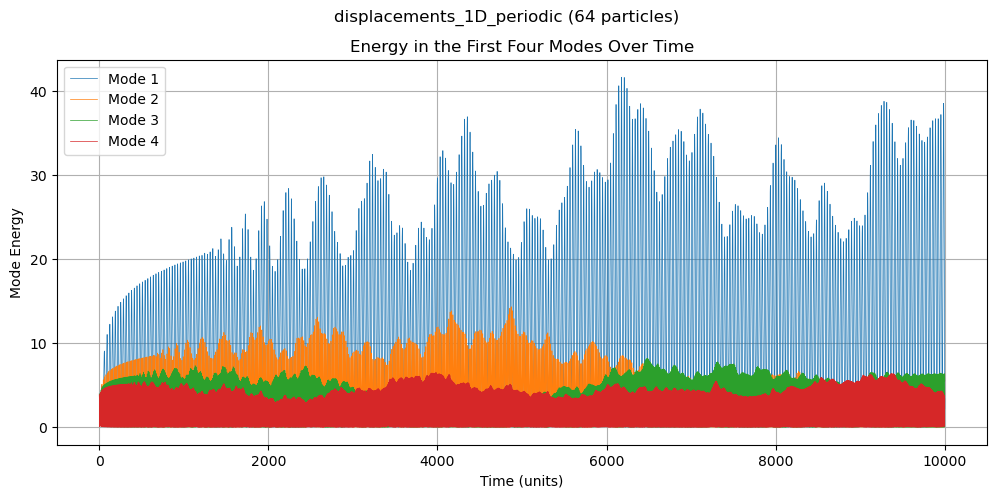

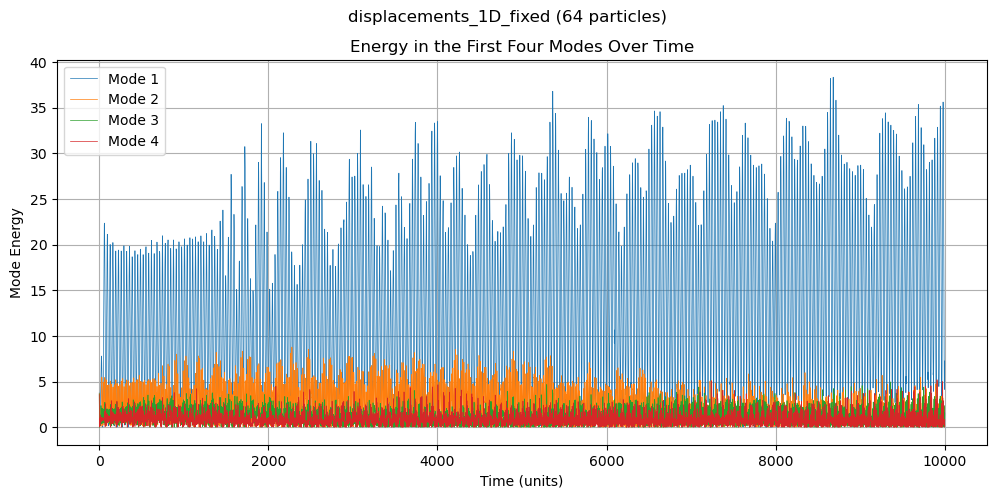

In [76]:
fft_plotter('displacements_1D_periodic', displacements_1D_periodic)
fft_plotter('displacements_1D_fixed', displacements_1D_fixed)


## ~~Phase Space Trajectories~~

In [77]:
def phase_space_plotter(filename, displacements, velocities):
    """
    Phase space plotter function

    Plots velocity against displacement in a phase space plot
    """
    particle_index = int(np.ceil(N / 2))

    plt.figure(figsize = (12, 5))
    plt.plot(displacements[:, particle_index], velocities[:, particle_index], c = 'b', lw = 0.5, ls = '-')

    #   Set plot limits and labels
    plt.grid(True)
    plt.xlabel('Displacement (units)')
    plt.ylabel('Velocity')
    plt.title(f'Phase Space Trajectory for Particle {particle_index}')
    plt.suptitle(f'{filename} ({N} particles)')
    plt.legend()

    #   Saves plot
    plt.savefig(f'./{config_str}/{filename}_{config_str}_phase_space.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

####################################################################################################
#                                                                                                  #
#                                    ABOVE CODE USED FOR SET UP                                    #
#                                                                                                  #
####################################################################################################

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


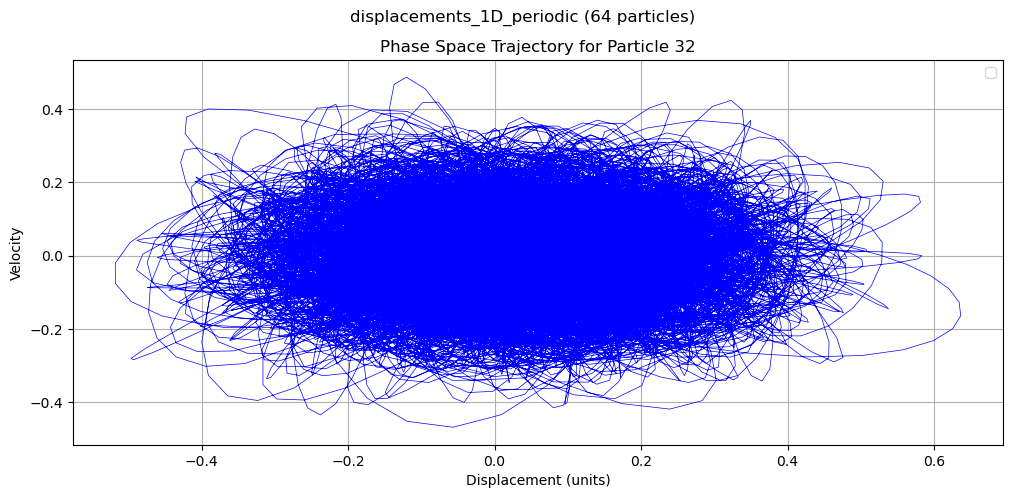

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


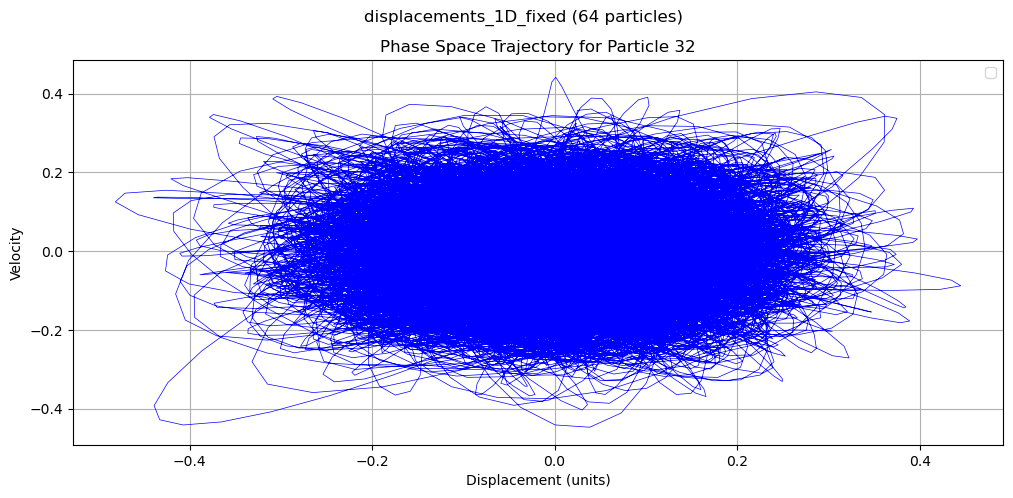

In [78]:
phase_space_plotter('displacements_1D_periodic', displacements_1D_periodic, velocities_1D_fixed)
phase_space_plotter('displacements_1D_fixed', displacements_1D_fixed, velocities_1D_periodic)


## Temperature Evolution
$$\left\langle E_{\operatorname{k}}\right\rangle = \frac{1}{2}m\left\langle v^2\right\rangle = \frac{1}{2}k_{\operatorname{B}}T$$
$$T \propto\left\langle v^2\right\rangle$$

In [79]:
def temperature_evolution(filename, velocities):
    """
    Temperature Evolution plotter function

    Plots system 'temperature' against time
    """
    plt.figure(figsize = (12, 5))
    temperature = np.mean(velocities ** 2, axis = 1)
    plt.plot(np.linspace(0, num_steps - 1, num_steps) * dt, temperature[:-1], c = 'b', lw = 0.5, ls = '-')

    #   Set plot limits and labels
    plt.grid(True)
    plt.xlabel('Time (units)')
    plt.ylabel('Tempearture')
    plt.title(f'Temperature Evolution of the system over time')
    plt.suptitle(f'{filename} ({N} particles)')

    #   Saves plot
    plt.savefig(f'./{config_str}/{filename}_{config_str}_temperature_evolution.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

####################################################################################################
#                                                                                                  #
#                                    ABOVE CODE USED FOR SET UP                                    #
#                                                                                                  #
####################################################################################################

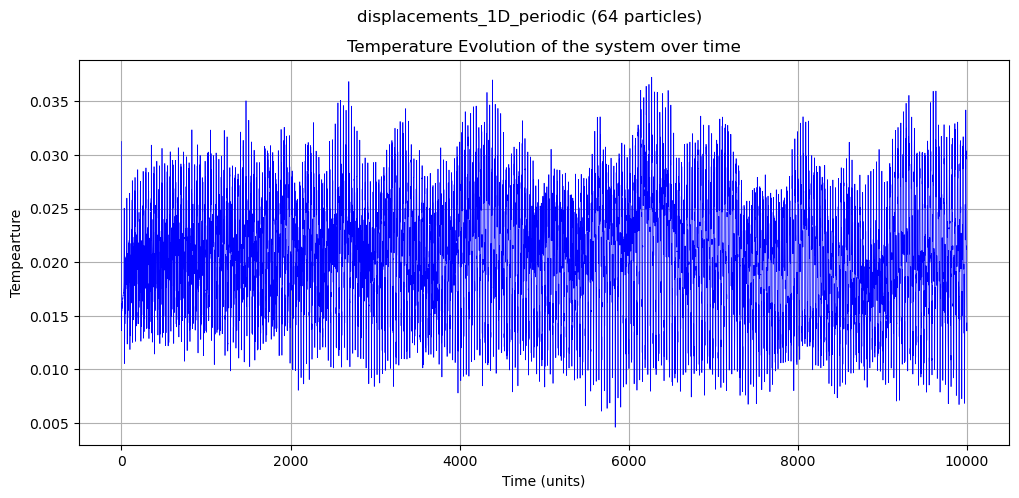

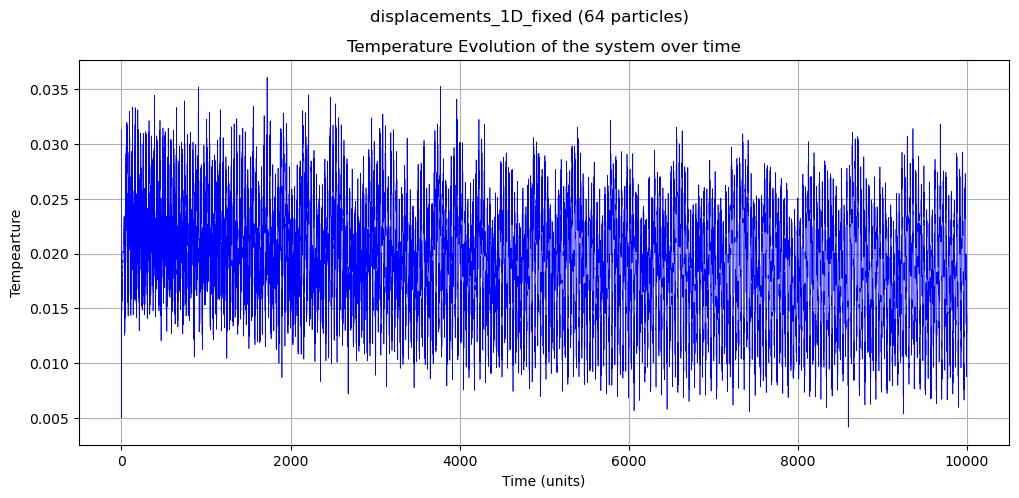

In [80]:
temperature_evolution('displacements_1D_periodic', displacements_1D_periodic)
temperature_evolution('displacements_1D_fixed', displacements_1D_fixed)
